<a href="https://colab.research.google.com/github/katrinag2004/wrangling/blob/main/scrapinglab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(67, 6)
                 count         mean          std    min     25%    50%  \
category                                                                 
air_conditioner    3.0   108.333333   101.036297    0.0   62.50  125.0   
coffee_machine     3.0   113.333333    62.516664   50.0   82.50  115.0   
microwave          4.0    98.500000    56.026779   20.0   80.00  112.5   
other             33.0   220.727273   452.287607    1.0   30.00   65.0   
refrigerator       9.0   186.111111   196.528907   20.0   80.00  120.0   
stove_oven         6.0  1387.500000  1616.922231  150.0  293.75  550.0   
washer_dryer       9.0   209.444444   149.026936    0.0   50.00  275.0   

                    75%     max  
category                         
air_conditioner   162.5   200.0  
coffee_machine    145.0   175.0  
microwave         131.0   149.0  
other             150.0  2500.0  
refrigerator      250.0   650.0  
stove_oven       2287.5  4000.0  
washer_dryer      325.0   400.0  


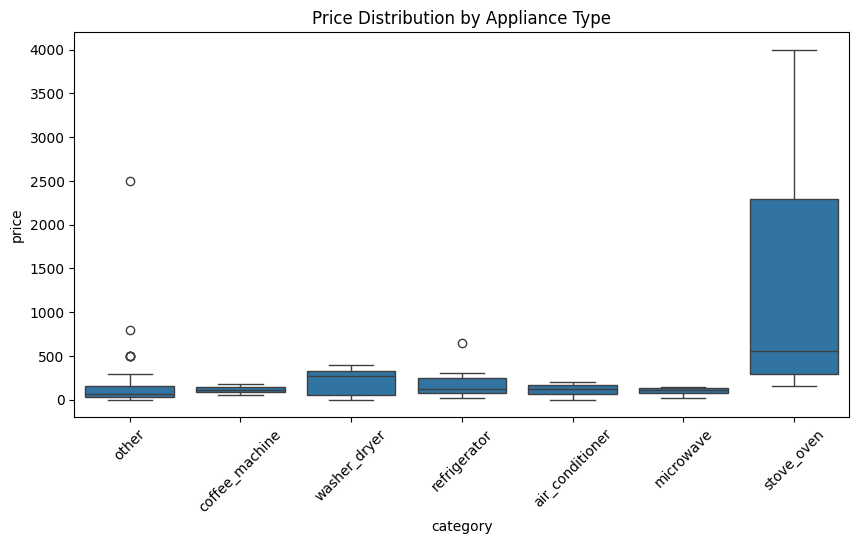

Series([], Name: count, dtype: int64)


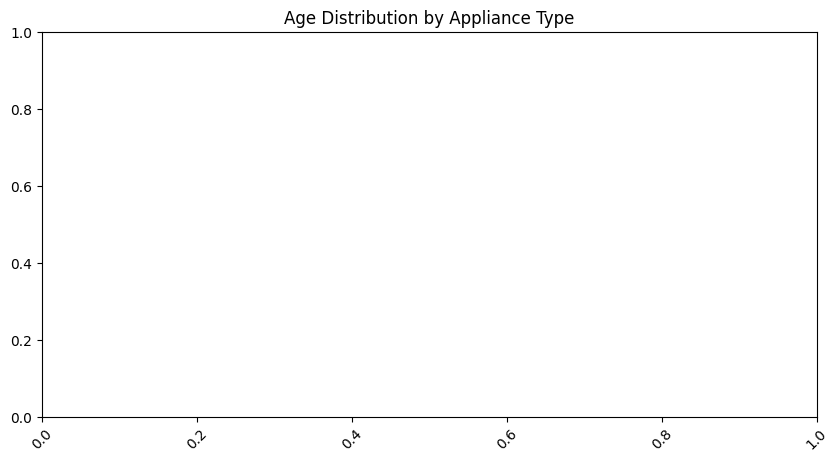

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup as soup
import re
import os

# Define headers and Craigslist URL
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/ppa#search=1~gallery~0~0'  # Page for appliances
raw = requests.get(url, headers=header)
bsObj = soup(raw.content, 'html.parser')

# Find all listings
listings = bsObj.find_all(class_="cl-static-search-result")

# Define appliance categories
appliance_types = {
    'refrigerator': ['fridge', 'refrigerator', 'freezer'],
    'washer_dryer': ['washer', 'dryer', 'laundry'],
    'dishwasher': ['dishwasher'],
    'microwave': ['microwave'],
    'stove_oven': ['stove', 'oven', 'range'],
    'coffee_machine': ['espresso', 'coffee'],
    'air_conditioner': ['AC', 'air conditioner'],
}

# Initialize data collection
data = []

for k in range(len(listings)):
    title = listings[k].find('div', class_='title').get_text().lower()
    price = listings[k].find('div', class_='price').get_text()
    link = listings[k].find(href=True)['href']

    # Determine appliance type
    appliance_category = 'other'
    for category, keywords in appliance_types.items():
        if any(keyword in title for keyword in keywords):
            appliance_category = category
            break

    # Extract year from title
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title)
    year = np.nan if regex_search is None else int(regex_search.group(0))

    data.append({'title': title, 'price': price, 'year': year, 'link': link, 'category': appliance_category})

# Convert to DataFrame
df = pd.DataFrame.from_dict(data)

# Clean up price column
df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Compute appliance age
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['age'] = 2025 - df['year']

# Save data to CSV
if not os.path.exists('./src'):
    os.makedirs('./src')
df.to_csv('./src/craigslist_cville_appliances.csv')

# Display data
print(df.shape)
df.head()

# **Basic Statistics**
print(df.groupby('category')['price'].describe())

# **Price Distribution by Appliance Type**
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='price', data=df)
plt.xticks(rotation=45)
plt.title('Price Distribution by Appliance Type')
plt.show()

# Remove missing values before plotting
df_clean = df.dropna(subset=['age'])

# Check if any categories are empty
print(df_clean['category'].value_counts())

# **Age Distribution by Appliance Type**
plt.figure(figsize=(10, 5))
sns.boxplot(x='category', y='age', data=df_clean)
plt.xticks(rotation=45)
plt.title('Age Distribution by Appliance Type')
plt.show()
